In [3]:
import pandas as pd

# Чтение входного CSV
df = pd.read_csv("scopus_MOO.csv")

# Оставляем только колонку с ключевыми словами
keywords_col = df.columns[1]      # предположим: 0 = ссылка, 1 = ключевые слова
df_clean = df[[keywords_col]].copy()

# Чистим: заменяем табы, множественные пробелы — на запятые
df_clean[keywords_col] = (
    df_clean[keywords_col]
    .astype(str)
    .str.replace(r"[\t]+", ", ", regex=True)
    .str.replace(r"\s{2,}", " ", regex=True)
    .str.replace(", ,", ",", regex=True)
    .str.strip()
)

# Переименуем колонку
df_clean.columns = ["AUTHOR KEYWORDS"]

# Сохраняем в Excel
df_clean.to_csv("scopus_MOO_clean.csv", index=False)

print("Готово: файл scopus_MOO_clean.xlsx создан")


Готово: файл scopus_MOO_clean.xlsx создан


In [1]:
import pandas as pd

# Чтение входного CSV
df = pd.read_csv("scopus_export_all.csv")
df

,Автор (ы),Author full names,Идентификатор автора(ов),Название документа,Год,Ссылка,Краткое описание,Ключевые слова автора
0,"Sankoju, A.S.; Shastri, Y.","Sankoju, Anupam Satyakam (60175620300); Shastr...",60175620300; 8620710400,Regional sustainability of food–energy–water n...,2026,https://www.scopus.com/inward/record.uri?eid=2...,"In this work, a regional optimization model is...",Energy–water nexus; Optimization; Regional sus...
1,"Kumar, G.; Sowlati, T.","Kumar, Gaurav (57639432100); Sowlati, Taraneh ...",57639432100; 7004194496,Hybrid Simulation Optimization Method for Biom...,2025,https://www.scopus.com/inward/record.uri?eid=2...,As the global demand for fossil-based products...,Agricultural biomass; Decision-making; Forest-...
2,"Panwar, P.; Singh, A.P.; Chauhan, A.; Arora, R.","Panwar, Prajwal (59744039600); Singh, Anubhav ...",59744039600; 57193881628; 57427305800; 5721123...,Optimization of a macro-algae-based biodiesel ...,2025,https://www.scopus.com/inward/record.uri?eid=2...,The rising consumption of fossil fuels and the...,Advertisement; Biodiesel; Genetic algorithm; M...
3,"Wang, S.; Ha, C.; Li, C.; Leng, S.; Xu, S.; Li...","Wang, Sibo (57191713227); Ha, Chan (5722448424...",57191713227; 57224484246; 58389015600; 5865979...,Performance evaluation of a biodiesel-methanol...,2025,https://www.scopus.com/inward/record.uri?eid=2...,In response to the International Maritime Orga...,3E analysis; Biodiesel; Green methanol; High t...
4,"Garcia, V.F.; Palacios-Bereche, R.; Ensinas, A.V.","Garcia, Victor Fernandes (58903619200); Palaci...",58903619200; 37561749200; 22134119000,A Multi-Objective Framework for Biomethanol Pr...,2025,https://www.scopus.com/inward/record.uri?eid=2...,The growing demand for renewable energy positi...,biomethanol production; heat integration; MILP...
...,...,...,...,...,...,...,...,...
309,"Zamboni, A.; Shah, N.; Bezzo, F.","Zamboni, Andrea (24438630900); Shah, Nilay G. ...",24438630900; 56846290400; 6602450288,Spatially explicit static model for the strate...,2009,https://www.scopus.com/inward/record.uri?eid=2...,In developing an optimization framework to ass...,NaN
310,"Gassner, M.; Maréchal, F.","Gassner, Martin (23034597500); Maréchal, Franç...",23034597500; 35605889100,"Methodology for the optimal thermo-economic, m...",2009,https://www.scopus.com/inward/record.uri?eid=2...,This paper addresses a methodology for the opt...,Biofuels; Optimisation; Process design; SNG; T...
311,"Gassner, M.; Maréchal, F.","Gassner, Martin (23034597500); Maréchal, Franç...",23034597500; 35605889100,Thermo-economic optimisation of the integratio...,2008,https://www.scopus.com/inward/record.uri?eid=2...,Converting wood to grid quality methane allows...,Bioenergy; Biofuels; Electrolysis; Gasificatio...
312,"Gassner, M.; Maréchal, F.","Gassner, Martin (23034597500); Maréchal, Franç...",23034597500; 35605889100,"Methodology for the optimal thermo-economic, m...",2007,https://www.scopus.com/inward/record.uri?eid=2...,This paper addresses a methodology for the opt...,Biofuels; optimisation.; process design; therm...


In [3]:
import os
import json
import pandas as pd
from datetime import datetime
from openai import OpenAI

# -------------------------------------------
# ЛОГИРОВАНИЕ — и в файл, и в консоль
# -------------------------------------------
LOGFILE = "classification_log.txt"

def log(msg: str):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    full_msg = f"[{timestamp}] {msg}"
    print(full_msg)
    with open(LOGFILE, "a", encoding="utf-8") as f:
        f.write(full_msg + "\n")

# -------------------------------------------
# Инициализация OpenAI
# -------------------------------------------
client = OpenAI(api_key="....."))

log("OpenAI client initialized.")

# -------------------------------------------
# Чтение CSV
# -------------------------------------------
log("Reading CSV file: scopus_export_all.csv")
df = pd.read_csv("scopus_export_all.csv")

required_cols = ["Название документа", "Краткое описание", "Ключевые слова автора", "Год"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    log(f"ERROR: Missing required columns: {missing}")
    raise ValueError(f"Missing required columns: {missing}")

log(f"Loaded {len(df)} rows.")

# -------------------------------------------
# Функция классификации
# -------------------------------------------
def classify_row(title: str, abstract: str, keywords: str) -> dict:
    title = "" if pd.isna(title) else str(title)
    abstract = "" if pd.isna(abstract) else str(abstract)
    keywords = "" if pd.isna(keywords) else str(keywords)

    log("Preparing prompt for classification...")
    prompt = f"""
You are classifying scientific articles about biofuels into three topics.

Topics:
1) Fuel Mixture Optimization and Engine Performance Enhancement
2) Optimizing Biomass Production and Processing to Maximize Yield
3) Streamlining Gasification and Pyrolysis Processes

Article data:
Title: {title}
Abstract: {abstract}
Author keywords: {keywords}

Return a STRICT JSON object:
{{
  "topic1": 0 or 1,
  "topic2": 0 or 1,
  "topic3": 0 or 1,
  "reason": "Explanation"
}}
"""

    log("Sending request to OpenAI API...")
    try:
        response = client.responses.create(
            model="gpt-4.1-mini",
            input=prompt,
            max_output_tokens=300,
        )
        log("Response received from OpenAI.")
    except Exception as e:
        log(f"ERROR during API call: {e}")
        return {"topic1": 0, "topic2": 0, "topic3": 0, "reason": f"API error: {e}"}

    raw = response.output_text
    log(f"Raw model output:\n{raw}")

    try:
        data = json.loads(raw)
        log("JSON parsed successfully.")
    except json.JSONDecodeError:
        log("ERROR: Failed to parse JSON.")
        return {
            "topic1": 0,
            "topic2": 0,
            "topic3": 0,
            "reason": f"Parsing error; raw model output: {raw[:500]}"
        }

    # Гарантируем корректность
    result = {
        "topic1": int(data.get("topic1", 0) or 0),
        "topic2": int(data.get("topic2", 0) or 0),
        "topic3": int(data.get("topic3", 0) or 0),
        "reason": str(data.get("reason", "No reason provided"))
    }

    log(f"Classification result: {result}")
    return result

# -------------------------------------------
# Основная обработка
# -------------------------------------------
topic1_list = []
topic2_list = []
topic3_list = []
reason_list = []

log("Starting article classification loop...")

for idx, row in df.iterrows():
    log(f"\n--- Processing row {idx+1}/{len(df)} ---")
    log(f"Title: {row['Название документа']}")

    result = classify_row(
        title=row["Название документа"],
        abstract=row["Краткое описание"],
        keywords=row["Ключевые слова автора"]
    )

    topic1_list.append(result["topic1"])
    topic2_list.append(result["topic2"])
    topic3_list.append(result["topic3"])
    reason_list.append(result["reason"])

    log(f"Row {idx+1} processed successfully.")

log("All rows processed. Adding new columns...")

# -------------------------------------------
# Добавление колонок
# -------------------------------------------
df["topic1"] = topic1_list
df["topic2"] = topic2_list
df["topic3"] = topic3_list
df["причина"] = reason_list

final_cols = [
    "Название документа",
    "Год",
    "Краткое описание",
    "Ключевые слова автора",
    "topic1",
    "topic2",
    "topic3",
    "причина"
]
final_cols = [c for c in final_cols if c in df.columns]

# -------------------------------------------
# Сохранение результата
# -------------------------------------------
output_file = "classified_articles.xlsx"
df[final_cols].to_excel(output_file, index=False)

log(f"Classification completed. File saved as {output_file}")
log("=== Job finished successfully ===")


[2025-12-09 13:20:28] OpenAI client initialized.
[2025-12-09 13:20:28] Reading CSV file: scopus_export_all.csv
[2025-12-09 13:20:28] Loaded 314 rows.
[2025-12-09 13:20:28] Starting article classification loop...
[2025-12-09 13:20:28] 
--- Processing row 1/314 ---
[2025-12-09 13:20:28] Title: Regional sustainability of food–energy–water nexus considering water stress using multi-objective modeling and optimization
[2025-12-09 13:20:28] Preparing prompt for classification...
[2025-12-09 13:20:28] Sending request to OpenAI API...
[2025-12-09 13:20:33] Response received from OpenAI.
[2025-12-09 13:20:33] Raw model output:
{
  "topic1": 0,
  "topic2": 1,
  "topic3": 0,
  "reason": "The article focuses on optimizing land allocation and water usage for crops and residues used in ethanol production, aiming to maximize yield and sustainability at a regional level. This aligns with optimizing biomass production and processing rather than engine performance or gasification/pyrolysis processes."
}

In [9]:
import pandas as pd

# Загружаем файл
df = pd.read_excel("classified_articles.xlsx")
df = df[df["Год"] >2020]

# Проверяем, что нужные колонки есть
required = ["topic1", "topic2", "topic3"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Не найдены колонки: {missing}")

# Подсчёт по темам
topic1_count = df["topic1"].sum()
topic2_count = df["topic2"].sum()
topic3_count = df["topic3"].sum()

# Статьи, которые НЕ попали никуда
unassigned_count = df[(df["topic1"] == 0) & (df["topic2"] == 0) & (df["topic3"] == 0)].shape[0]

# Общее число статей
total_count = len(df)

# Финальный вывод
print("\n===== FINAL TOPIC COUNTS =====")
print(f"Total articles: {total_count}")
print(f"Topic 1 (Fuel Mixture Optimization): {topic1_count}")
print(f"Topic 2 (Biomass Production Optimization): {topic2_count}")
print(f"Topic 3 (Gasification & Pyrolysis): {topic3_count}")
print(f"Unassigned (no topic): {unassigned_count}")
print("================================\n")



===== FINAL TOPIC COUNTS =====
Total articles: 182
Topic 1 (Fuel Mixture Optimization): 49
Topic 2 (Biomass Production Optimization): 80
Topic 3 (Gasification & Pyrolysis): 20
Unassigned (no topic): 40



In [8]:
df[df["Год"] >2020]

,Название документа,Год,Краткое описание,Ключевые слова автора,topic1,topic2,topic3,причина
0,Regional sustainability of food–energy–water n...,2026,"In this work, a regional optimization model is...",Energy–water nexus; Optimization; Regional sus...,0,1,0,The article focuses on optimizing land allocat...
1,Hybrid Simulation Optimization Method for Biom...,2025,As the global demand for fossil-based products...,Agricultural biomass; Decision-making; Forest-...,0,1,0,The article focuses on biomass supply chain pl...
2,Optimization of a macro-algae-based biodiesel ...,2025,The rising consumption of fossil fuels and the...,Advertisement; Biodiesel; Genetic algorithm; M...,0,1,0,The article focuses on optimizing the biodiese...
3,Performance evaluation of a biodiesel-methanol...,2025,In response to the International Maritime Orga...,3E analysis; Biodiesel; Green methanol; High t...,1,0,0,The article focuses on evaluating and optimizi...
4,A Multi-Objective Framework for Biomethanol Pr...,2025,The growing demand for renewable energy positi...,biomethanol production; heat integration; MILP...,0,1,1,The article focuses on optimizing biomethanol ...
...,...,...,...,...,...,...,...,...
177,A multi-objective life cycle optimization mode...,2021,Biofuel production from microalgae biomass has...,Algal biofuel; Algal biorefinery; Life cycle o...,0,1,0,The article focuses on optimizing an integrate...
178,Cost-effective subsidy policy for growers and ...,2021,The purpose of present study is twofold. First...,Biofuels; Closed-loop supply chain; Interactiv...,0,0,0,Parsing error; raw model output: ```json\n{\n ...
179,Multidimensional aspects of sustainable biofue...,2021,Bioenergy is becoming increasingly relevant as...,Bioenergy; Carbon sequestration; Life cycle an...,0,1,0,The article focuses on optimizing bioenergy fe...
180,A novel approach for bio-lubricant production ...,2021,Due to the damaging environmental impacts resu...,Bio-lubricant; Energy efficient process; Inten...,0,1,0,The article focuses on optimizing the producti...


                 Country  Value
0                  India     77
1          United States     52
2                   Iran     41
3                  China     33
4                  Italy     18
..                   ...    ...
57             Undefined      1
58  United Arab Emirates      1
59               Uruguay      1
60              Viet Nam      1
61                 Yemen      1

[62 rows x 2 columns]


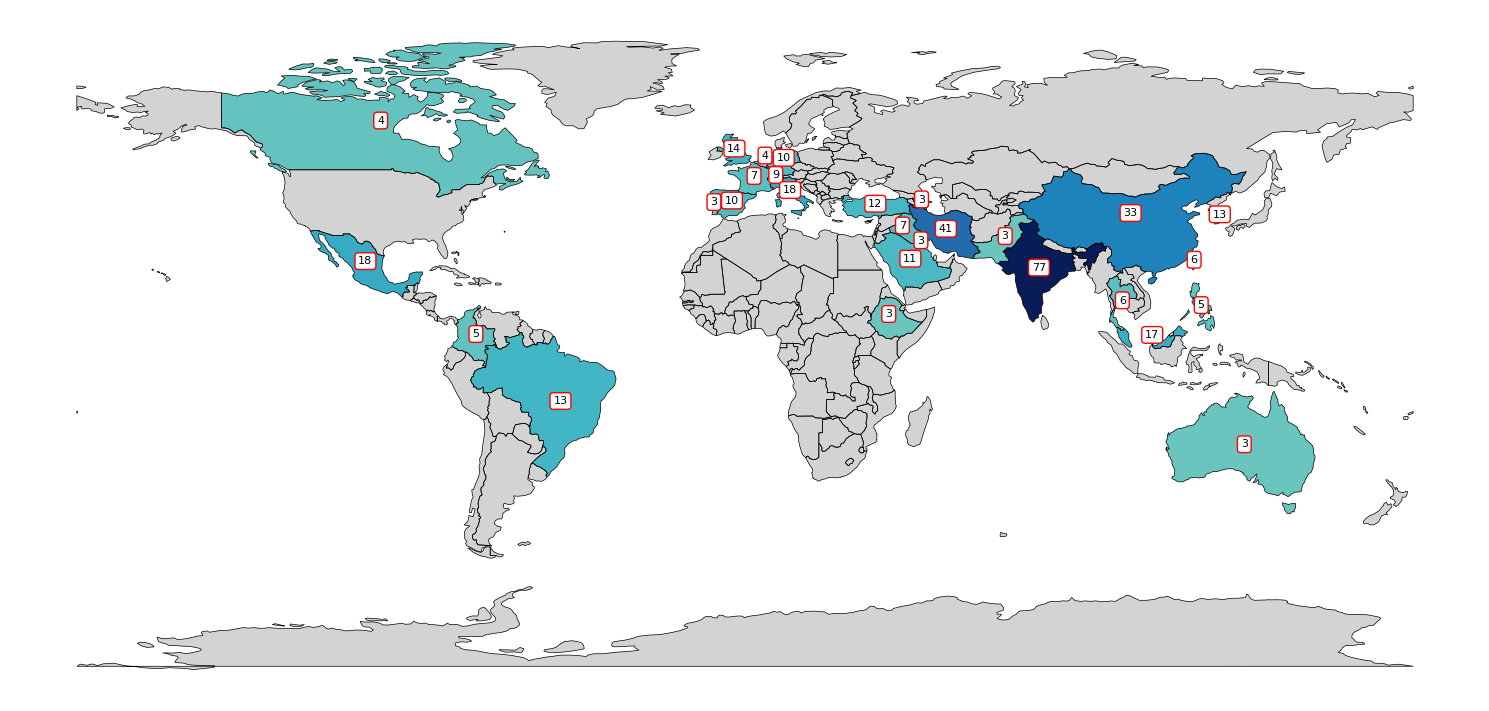

In [6]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

def plot_world_map_with_annotations(file_path):
    # Load the data from the CSV file, skipping the metadata rows
    data = pd.read_csv(file_path, delimiter=",")
    
    # Rename the columns for clarity
    data.columns = ['Country', 'Value']
    print(data)
    # Remove quotes around the numbers and convert 'Value' to numeric
    #data['Value'] = data['Value'].replace({r'"': '', r',': ''}, regex=True)  # Remove quotes and commas
    #data['Value'] = pd.to_numeric(data['Value'], errors='coerce')  # Convert to numeric, invalid values become NaN
    
    # Exclude records with 'Undefined' and filter by Value > 60
    data = data[data['Country'] != 'Undefined']
    data = data[data['Value'] > 2]

    # Load a base world map using geodatasets
    world = gpd.read_file("https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json")

    # Merge the world map with the data based on the country name
    world = world.merge(data, how='left', left_on='name', right_on='Country')

    # Fill NaN values in the 'Value' column with 0 (countries not in the data will be gray)
    world['Value'] = world['Value'].fillna(0)

    # Define a colormap where 0 is explicitly gray
    cmap = ListedColormap(["lightgray"] + plt.cm.YlGnBu(np.linspace(0.4, 1.0, 256)).tolist())

    # Plot the map
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    world.boundary.plot(ax=ax, linewidth=0.5, color='black')  # Plot boundaries of all countries
    world.plot(column='Value', ax=ax, legend=False, cmap=cmap, 
               missing_kwds={"color": "lightgray"})

    # Add annotations for each country
    for _, row in world.iterrows():
        if row['Value'] > 0:  # Only annotate countries with a value > 0
            # Get the centroid of the country geometry for text placement
            if row['geometry'].geom_type == 'MultiPolygon':
                point = row['geometry'].centroid
            else:
                point = row['geometry'].representative_point()

            # Add the value as text with a red box and white background
            ax.text(
                x=point.x, y=point.y, s=str(int(row['Value'])), ha='center', fontsize=8,
                bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3')
            )

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.YlGnBu, 
                               norm=plt.Normalize(vmin=world['Value'].min(), 
                                                  vmax=world['Value'].max()))
    
    # Set title and remove axes
    ax.axis('off')  # Remove axis for cleaner visualization

    # Save the map to a file
    plt.tight_layout()
    plt.savefig('world_map_with_annotations.pdf', format='pdf')
    plt.show()

# Example usage:
file_path = 'Scopus-314-Analyze-Country.csv'
plot_world_map_with_annotations(file_path)


             Doctype  Value
0            Article    314
1   Conference Paper     34
2       Book Chapter     28
3             Review     11
4  Conference Review      3
5               Book      2


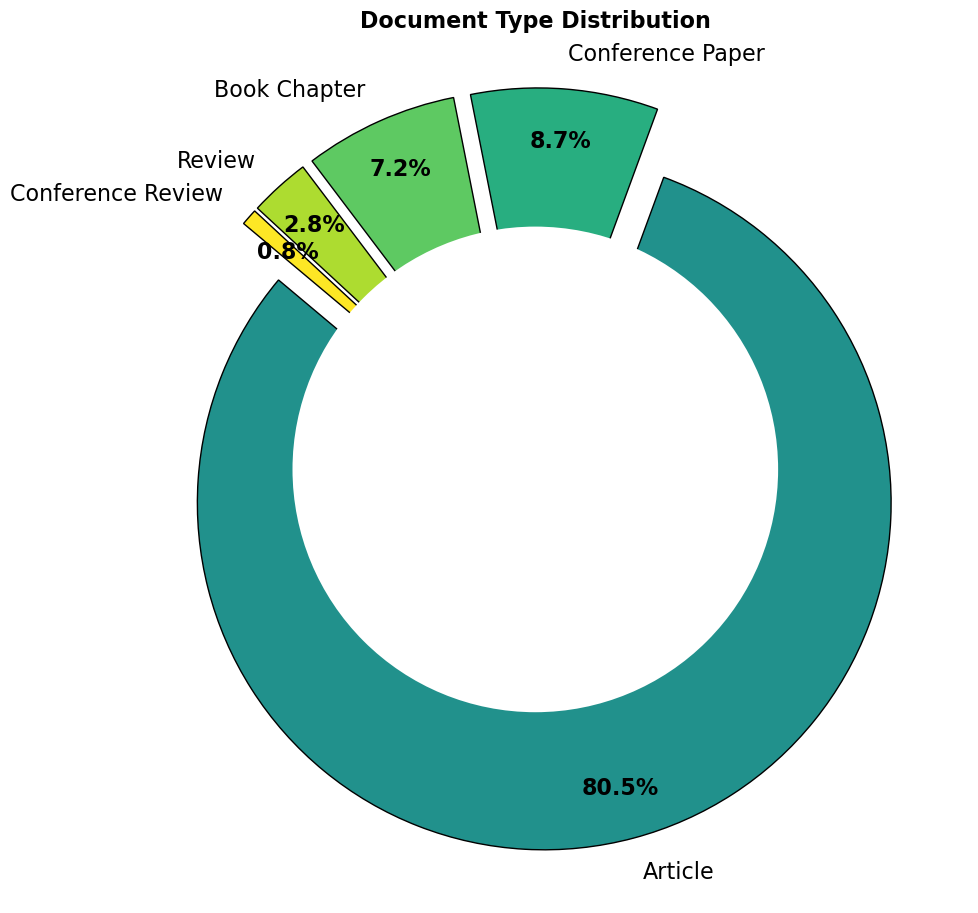

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_doctype_distribution(file_path):
    # Load the data from the CSV file
    data = pd.read_csv(file_path)  # Assuming header is on the 4th row (0-indexed 3)
    print(data)
    # Rename the columns for clarity (Assuming the columns are named 'Doctype' and 'Value')
    data.columns = ['Doctype', 'Value']

    # Exclude records with 'Undefined'
    data = data[data['Doctype'] != 'Undefined']
    data = data[data['Value']>2]
    
    # Extracting document types and their corresponding values
    doctypes = data['Doctype'].tolist()
    values = data['Value'].tolist()

    # Define the explode parameter for visual effect (optional)
    explode = [0.1] * len(doctypes)  # Explode all slices for better visibility

    # Using 'viridis' colormap, but only from 0.4 to 1.0 (to avoid dark colors)
    viridis_colors = plt.cm.viridis(np.linspace(0.5, 1.0, len(values)))

    # Create figure
    plt.figure(figsize=(10, 10))

    # Create pie chart with gradient colors and black edges around each segment
    wedges, texts, autotexts = plt.pie(
        values, labels=doctypes, autopct='%1.1f%%', startangle=140,
        explode=explode, colors=viridis_colors, pctdistance=0.85, labeldistance=1.1,
        wedgeprops={"edgecolor": "black"}  # Add black edges for each segment
    )

    # Customize text
    for text in texts:
        text.set_fontsize(16)
        text.set_color("black")  # Set document type label color to black for readability
    for autotext in autotexts:
        autotext.set_color("black")  # Set percentage label color to black
        autotext.set_fontsize(16)
        autotext.set_weight("bold")

    # Add a central circle for donut effect
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    plt.gca().add_artist(centre_circle)

    # Set the title
    plt.title("Document Type Distribution", fontsize=16, weight='bold')
    plt.tight_layout()

    # Save the plot to PDF
    plt.savefig('doctype_distribution.pdf', format='pdf')
    plt.show()  # Close the plot to free up memory

# Example usage:
file_path = 'Scopus-10-Analyze-Doctype.csv'
plot_doctype_distribution(file_path)


    Year  Count
0   2025     46
1   2024     28
2   2023     38
3   2022     36
4   2021     33
5   2020     14
6   2019     25
7   2018     19
8   2017     11
9   2016     15
10  2015      5
11  2014     12
12  2013     11
13  2012      8
14  2011      6
15  2010      1
16  2009      2
17  2008      1
18  2007      1
19  2001      1


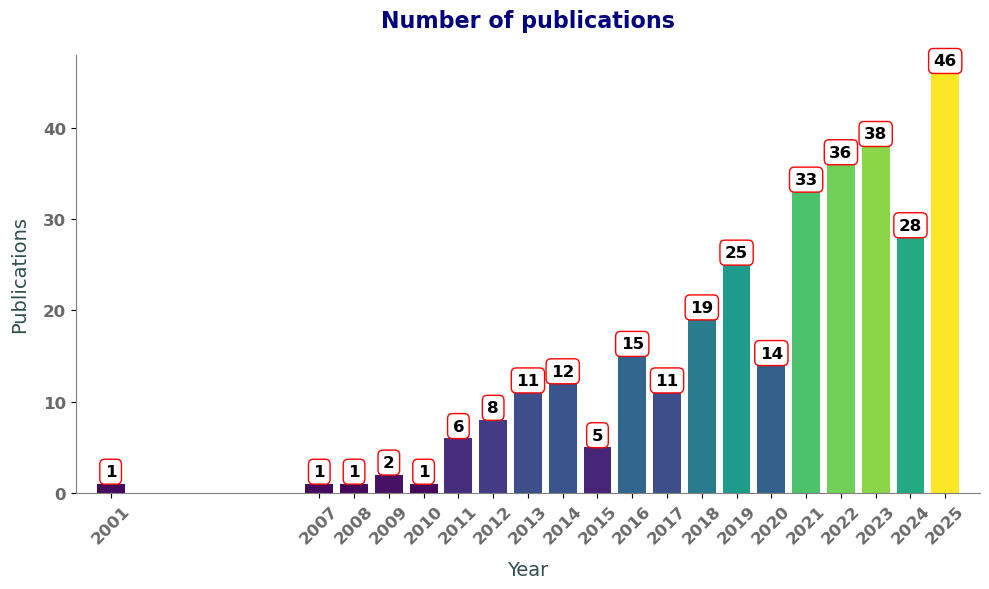

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_data_distribution(file_path):
    # Load the data from the CSV file
    data = pd.read_csv(file_path, header=4)  # Specify that the header is on the 4th row (0-indexed 3)

    # Rename the columns for clarity
    data.columns = ['Year', 'Count']
    print(data)
    # Sorting the data by year in ascending order
    sorted_data = data.sort_values(by='Year')

    # Extracting sorted years and corresponding counts
    sorted_years = sorted_data['Year'].tolist()
    sorted_counts = sorted_data['Count'].tolist()

    # Set up the figure and axis
    plt.figure(figsize=(10, 6))

    # Normalize the count values for color mapping
    norm_counts = np.array(sorted_counts) / max(sorted_counts)  # Normalize counts for colormap range
    colors = plt.cm.viridis(norm_counts)  # Map normalized counts to viridis colormap

    # Create bars with gradient colors
    plt.bar(sorted_years, sorted_counts, color=colors, edgecolor='none')  # edgecolor set to 'none' to remove lines

    # Adding value labels in bounding boxes
    for year, value in zip(sorted_years, sorted_counts):
        plt.text(
            year,
            value + 0.5,  # Positioning text slightly above the top of the bar
            f"{value}",
            ha='center',
            va='bottom',
            fontsize=12,
            fontweight='bold',
            bbox=dict(facecolor="white", edgecolor="red", boxstyle="round,pad=0.3")  # White background with red border
        )

    # Adding title and labels
    plt.title("Number of publications", fontsize=16, weight='bold', pad=20, color="navy")
    plt.xlabel("Year", fontsize=14, labelpad=10, color="darkslategray")
    plt.ylabel("Publications", fontsize=14, labelpad=10, color="darkslategray")

    # Customizing the axes
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_color('gray')
    plt.gca().spines['bottom'].set_color('gray')
    plt.xticks(color="dimgray", fontsize=12, weight='bold', rotation=45)
    plt.yticks(color="dimgray", fontsize=12, weight='bold')

    # Установка меток по оси X с пропуском по годам
    plt.xticks(ticks=sorted_years, labels=sorted_years)
    plt.xlim(sorted_years[0] - 1, sorted_years[-1] + 1)  # Установка пределов оси X
    plt.ylim(0, max(sorted_counts) + 2)  # Установка пределов оси Y для лучшей визуализации

    # Save plot to PDF
    plt.tight_layout()
    plt.savefig('data_distribution_by_year.pdf')
    plt.show()

# Example usage:
file_path = 'Scopus-10-Analyze-Year.csv'
plot_data_distribution(file_path)
